# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">2. Model Training for Gemstone Dataset - Utkarsh Gaikwad</p>

### Loading the necessary Libraries

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Read the Dataset</p>

In [2]:
df = pd.read_csv('./data/gemstone.csv')
df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


### Dropping id Column

In [3]:
df = df.drop(labels=['id'],axis=1)

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Ordinal Mapping of Categorical Variables</p>

### Create a custom ordinal mapper for cut, clarity, and color

In [4]:
cut_mapper = {"Fair":1, "Good":2, "Very Good":3 , "Premium":4 ,"Ideal":5}
clarity_mapper = {"I1":1,"SI2":2 ,"SI1":3 ,"VS2":4 , "VS1":5 , "VVS2":6 , "VVS1":7 ,"IF":8}
color_mapper = {"D":1 ,"E":2 ,"F":3 , "G":4 ,"H":5 , "I":6, "J":7}

### Use above mapping to perform ordinal encoding

In [5]:
df['cut'] = df['cut'].replace(cut_mapper)
df['clarity'] = df['clarity'].replace(clarity_mapper)
df['color'] = df['color'].replace(color_mapper)

In [6]:
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.52,4,3,4,62.2,58.0,7.27,7.33,4.55,13619
1,2.03,3,7,2,62.0,58.0,8.06,8.12,5.05,13387
2,0.70,5,4,5,61.2,57.0,5.69,5.73,3.50,2772
3,0.32,5,4,5,61.6,56.0,4.38,4.41,2.71,666
4,1.70,4,4,4,62.6,59.0,7.65,7.61,4.77,14453


# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Getting X and Y variables</p>

In [7]:
X = df.drop(labels=['price'],axis=1)
Y = df[['price']]

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Train Test Split</p>

In [8]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.2,random_state=42)

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Standard Scaling</p>

In [9]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
xtrain = pd.DataFrame(ss.fit_transform(xtrain),columns=xtrain.columns)
xtest = pd.DataFrame(ss.transform(xtest),columns=xtest.columns)

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Model Training Baseline models</p>

### Create an Evaluate Function to give all metrics after model Training

In [12]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

### Training Various models

In [15]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(xtrain, ytrain.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1016.9490
- Mean Absolute Error: 677.1656
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.6010
- Mean Absolute Error: 671.5856
- R2 Score: 0.9373


Lasso
Model performance for Training set
- Root Mean Squared Error: 1017.0716
- Mean Absolute Error: 678.3178
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.8713
- Mean Absolute Error: 672.8665
- R2 Score: 0.9373


Ridge
Model performance for Training set
- Root Mean Squared Error: 1016.9491
- Mean Absolute Error: 677.1925
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.6062
- Mean Absolute Error: 671.6137
- R2 Score: 0.9373


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 545.6563
- Mean Absolute Error: 285.8181
- R2 Sco

### Results

In [16]:
df_results = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
df_results

,Model Name,R2_Score
7,CatBoosting Regressor,0.979310
6,XGBRegressor,0.978634
5,Random Forest Regressor,0.977225
3,K-Neighbors Regressor,0.972114
4,Decision Tree,0.957318
0,Linear Regression,0.937298
2,Ridge,0.937297
1,Lasso,0.937264
8,AdaBoost Regressor,0.884070


# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Hyperparameter tuning</p>

### Tuning Catboost

In [30]:
# Initializing catboost
cbr = CatBoostRegressor(verbose=False)

# Creating the hyperparameter grid
param_dist = {'depth'          : [4,5,6,7,8,9, 10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
               'iterations'    : [300,400,500,600]}

#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbr , param_dist, scoring='r2', cv =5)

# Fit the model
rscv.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.03, 'iterations': 400, 'depth': 10}
0.9797616295362527


### Definition to print evaluated model results

In [42]:
def print_evaluated_results(model,xtrain,ytrain,xtest,ytest):
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, ytrain_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, ytest_pred)

    # Printing results
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))

In [43]:
# Selecting best model
best_cbr = rscv.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_cbr,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 553.7562
- Mean Absolute Error: 292.2578
- R2 Score: 0.9812
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 574.5256
- Mean Absolute Error: 296.1035
- R2 Score: 0.9796


### Tuning KNN

In [50]:
from sklearn.model_selection import GridSearchCV
# Initialize knn
knn = KNeighborsRegressor()

# parameters
k_range = list(range(2, 31))
param_grid = dict(n_neighbors=k_range)

# Fitting the cvmodel
grid = GridSearchCV(knn, param_grid, cv=5, scoring='r2')
grid.fit(xtrain, ytrain)

# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 16}
0.9736029540386621


In [51]:
# Selecting best model
best_knn = grid.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_knn,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 610.3458
- Mean Absolute Error: 319.3932
- R2 Score: 0.9772
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 643.8459
- Mean Absolute Error: 336.3468
- R2 Score: 0.9743


# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Voting Regressor</p>

In [57]:
from sklearn.ensemble import VotingRegressor

er = VotingRegressor([('cbr',best_cbr),('knn',best_knn),('xgb',XGBRegressor())], weights=[3,1,2])
er.fit(xtrain, ytrain.values.flatten())

print_evaluated_results(er,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 532.1077
- Mean Absolute Error: 281.9693
- R2 Score: 0.9826
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 575.1933
- Mean Absolute Error: 293.6436
- R2 Score: 0.9795


### Model not improving with Ensemble technique use best model i.e. tuned catboost

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Catboost Model Feature Importances</p>

carat      27.451317
clarity    18.242453
x          15.536166
y          15.450887
color      13.284241
z           9.059232
cut         0.540746
table       0.258109
depth       0.176849
dtype: float64




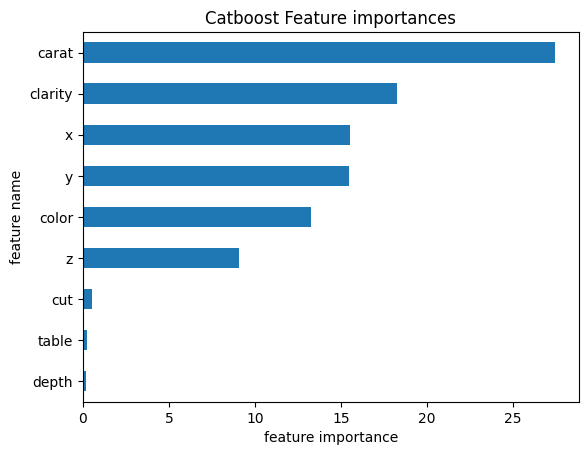

In [88]:
feature_imp = best_cbr.feature_importances_
feature_nm = best_cbr.feature_names_
imp_series = pd.Series(feature_imp)
imp_series.index = feature_nm
print(imp_series.sort_values(ascending=False))
print('\n')
imp_series.sort_values().plot(kind='barh',
                              xlabel='feature importance',
                              ylabel='feature name',
                              title='Catboost Feature importances')
plt.show()